<a href="https://colab.research.google.com/github/grace3999/PPs/blob/master/4_FIFI_image_CNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import os
import requests 
from multiprocessing.pool import ThreadPool
import time
import random
from shutil import copyfile
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
#path for FIFI cleaned and preprocessed data frame
path_FIFI = '/content/gdrive/My Drive/WIDS_FIFI_groupproject/generated_datasets/data_final.pkl'

#read in pkl file containing 
data = pd.read_pickle(path_FIFI)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)

print('Original data shape:\n', data.shape, '\n')

#clean data, combine 'sign/signal' and 'streetlight' 
data = data[data['FIFI_category'] != 'Community Walk']
data['FIFI_category'] = data['FIFI_category'].replace({'Needles/Dumping': 'Needles_Dumping', 'Sign/Signal': 'Sign_Signal_Light', 'Streetlight': 'Sign_Signal_Light'})

#we are only interested in FIFI requests that have a photo included with the request
print(data.shape)
data_photo = data[~data['Photo'].isna()]
print(data_photo.shape)

print(data_photo['FIFI_category'].value_counts())

Original data shape:
 (248815, 67) 

(248661, 67)
(183278, 67)
Needles_Dumping      40265
Other                34428
Grafitti             31749
Abnd_Vehicle         26656
Parking              25140
Pothole              13154
Sign_Signal_Light    11398
Clogged_Drain        427  
Vegetation           44   
Dead Animal          17   
Name: FIFI_category, dtype: int64


In [0]:
#create a directory for each category
try:
    os.mkdir('/tmp/FIFI_photos/')
except:
    pass

save_path = '/tmp/FIFI_photos/'

train_cats = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Sign_Signal_Light']

for cat in train_cats:
    if os.path.exists(os.path.join(save_path, cat)) == True:
      print(cat, " already exists")
    else:
      os.mkdir(os.path.join(save_path, cat))
      print(cat, " directory created")

Abnd_Vehicle  directory created
Grafitti  directory created
Needles_Dumping  directory created
Parking  directory created
Pothole  directory created
Sign_Signal_Light  directory created


In [0]:
#create function to get photo from url and save
def fetch_and_save(image_url_tupple):
    image_name, image_url = image_url_tupple
    #create file name for photo
    image_name = os.path.join(save_path_cat, image_name)  
    #get photo from url and save
    r = requests.get(image_url, allow_redirects=True)
    open(image_name, 'wb').write(r.content)

#use '/tmp/' for faster performance
save_path = '/tmp/FIFI_photos/'

#do each category individually, limit to 10,000 (lowest cat count)
for cat in train_cats:
  print(cat)
  cat_data = data_photo[data_photo['FIFI_category'] == cat].reset_index() 
  save_path_cat = os.path.join(save_path, cat)

  i = 0
  while i < (1500):
    if i%500 == 0:
      print(i)
    #run on multiple threads for faster performance, save each photo with 'service_request_number' for later indexing
    urls = list(zip([cat+'_'+str(x)+'.jpeg' for x in cat_data['Service_Request_Number'].iloc[i:i+5]], cat_data['Photo'][i:i+5]))
    ThreadPool(5).imap_unordered(fetch_and_save, urls)
    i += 5

Abnd_Vehicle
0
500
1000
Grafitti
0
500
1000
Needles_Dumping
0
500
1000
Parking
0
500
1000
Pothole
0
500
1000
Sign_Signal_Light
0
500
1000


In [0]:
#create directories for training and testing 
project_dir = '/tmp/'

try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/training'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/testing'))
except OSError:
  pass


In [0]:
#create directories for train/test for each FIFI category 
photo_categories = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Sign_Signal_Light']

train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  try:
    os.mkdir(os.path.join(train_dir, cat))
  except OSError:
   print('cannot make directory for train: ', cat)
  try:
    os.mkdir(os.path.join(test_dir, cat))
  except OSError:
   print('cannot make directory for test: ', cat)

In [0]:
#function to split data into training and testing based on a specified split size
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)

In [0]:
photos_dir = '/tmp/FIFI_photos/'
train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  print(cat)
  source_dir = os.path.join(photos_dir, cat)
  train_dir_cat = os.path.join(train_dir, cat)
  test_dir_cat = os.path.join(test_dir, cat)

  split_size = .9
  start_time = time.time()
  split_data(source_dir, train_dir_cat, test_dir_cat, split_size)
  print("--- %s seconds ---" % (time.time() - start_time))


Abnd_Vehicle
--- 0.5065953731536865 seconds ---
Grafitti
--- 0.4317653179168701 seconds ---
Needles_Dumping
--- 1.2458741664886475 seconds ---
Parking
--- 0.6138372421264648 seconds ---
Pothole
--- 0.5498065948486328 seconds ---
Sign_Signal_Light
--- 1.5820708274841309 seconds ---


In [0]:
#train CNN using images from each category besides 'other'

TRAINING_DIR = '/tmp/cnn_cat_other/training/'
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = '/tmp/cnn_cat_other/testing/'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=15, validation_data = validation_generator, verbose = 1)

#model.save("rps.h5")


Found 7795 images belonging to 6 classes.
Found 867 images belonging to 6 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_____________________________________

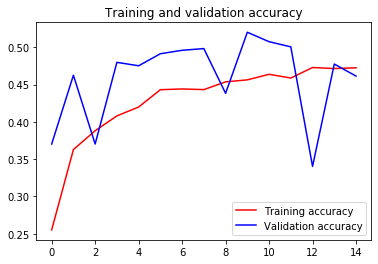

<Figure size 432x288 with 0 Axes>

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()